# Main Configs

In [2]:
small_df = False
batch_size = 10
n_epochs = 14
width, height = 300, 300

# Setup and Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
!pip install -qU torch_snippets

     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 8.1 MB/s 
     |████████████████████████████████| 948 kB 77.5 MB/s 
     |████████████████████████████████| 10.9 MB 47.9 MB/s 
     |████████████████████████████████| 60 kB 8.7 MB/s 
     |████████████████████████████████| 229 kB 97.2 MB/s 
     |████████████████████████████████| 78 kB 10.0 MB/s 
     |████████████████████████████████| 51 kB 9.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [5]:
!git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
/content/ssd-utils


In [6]:
import copy
import glob
import torch
import time
import statistics
import pandas as pd
import collections

from os.path import join
from torch_snippets import *
from PIL import Image

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
IMAGE_ROOT = '/content/drive/MyDrive/BA/dataset/bus-trucks/images'
OUTPUT_REPORTS = '/content/drive/MyDrive/BA/Notebooks/2_Experiment/Output_Reports'
OUTPUT_MODELS = '/content/drive/MyDrive/BA/Notebooks/2_Experiment/Output_Models'
output_training_report = 'ssd_vgg16.csv'
output_model_name = 'ssd_vgg16.pt'

In [9]:
df_train = pd.read_csv('/content/drive/MyDrive/BA/dataset/Experimente/df_80_20_train_tf.csv')
df_test = pd.read_csv('/content/drive/MyDrive/BA/dataset/Experimente/df_80_20_test_tf.csv')
df_train.head()

,filename,class,xmin,xmax,ymin,ymax
0,0000599864fd15b3.jpg,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74.jpg,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74.jpg,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab.jpg,Bus,0.156250,0.371250,0.269188,0.705228
4,00036603fa39fa85.jpg,Truck,0.058125,0.983125,0.053333,0.940000


In [15]:
label2target = {l:t+1 for t,l in enumerate(df_train['class'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
label2target = {v: k for k, v in target2label.items()}
background_class = label2target['background']
num_classes = len(label2target)

print(target2label)

{1: 'Bus', 2: 'Truck', 0: 'background'}


In [16]:
from torchvision import transforms

def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [17]:
class OpenDataset(torch.utils.data.Dataset):
  w, h = width, height
  def __init__(self, df, image_dir=IMAGE_ROOT):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'/*')
    self.df = df
    self.image_infos = df['filename'].unique()

  def __getitem__(self, ix):

    #filename	class	xmin	xmax	ymin	ymax

    # # load images and masks
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.

    data = self.df[self.df['filename'] == image_id]
    labels = data['class'].values.tolist()
    data = data[['xmin','ymin','xmax','ymax']].values
    data[:,[0,2]] *= self.w
    data[:,[1,3]] *= self.h
    boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
    return img, boxes, labels

  def collate_fn(self, batch):
    images, boxes, labels = [], [], []
    for item in batch:
      img, image_boxes, image_labels = item
      img = preprocess_image(img)[None]
      images.append(img)
      boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
      labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
    images = torch.cat(images).to(device)
    return images, boxes, labels

  def __len__(self):
    return len(self.image_infos)

In [18]:
if small_df:
  df_train = df_train[:50]
  df_test = df_test[:50]

In [19]:
train_ds = OpenDataset(df_train)
test_ds = OpenDataset(df_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn, drop_last=True)

# Train Model

In [20]:
from model import SSD300, MultiBoxLoss
from detect import *

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [21]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model, criterion):
    model.eval() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [23]:
epochs_summary = []

for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
      start = time.time()
      loss = train_batch(inputs, model, criterion, optimizer)
      end = time.time()

      pos = (epoch + (ix+1)/_n)
      log.record(pos, trn_loss=loss.item(), end='\r')

      epochs_summary.append(
        {
          'epoch': int(epoch),
          'time': float((end-start)),
          'loss': loss.item()
        }
      )

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')
    try:
      if (epoch+1)%(n_epochs//5)==0:
        log.report_avgs(epoch+1)
    except Exception as e:
      print()
      print('Exception', e)
      print('Epoch', epoch)

EPOCH: 2.000	trn_loss: 2.882	val_loss: 2.760	(14510.69s - 87064.11s remaining)
EPOCH: 4.000	trn_loss: 2.140	val_loss: 2.489	(16062.28s - 40155.71s remaining)
EPOCH: 6.000	trn_loss: 1.708	val_loss: 2.490	(17613.86s - 23485.15s remaining)
EPOCH: 8.000	trn_loss: 1.376	val_loss: 2.767	(19162.35s - 14371.76s remaining)
EPOCH: 10.000	trn_loss: 1.110	val_loss: 3.115	(20711.17s - 8284.47s remaining)
EPOCH: 12.000	trn_loss: 0.917	val_loss: 3.367	(22255.99s - 3709.33s remaining)
EPOCH: 14.000	trn_loss: 0.759	val_loss: 3.904	(23797.86s - 0.00s remaining)


# Analyzing results

100%|██████████| 115/115 [00:00<00:00, 170.51it/s]


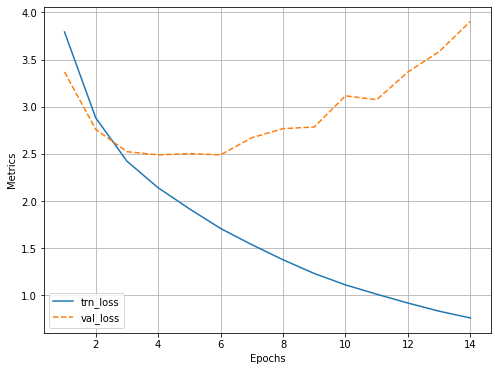

In [24]:
log.plot_epochs(['trn_loss','val_loss'])

# Save results

In [25]:
df_training_result = pd.DataFrame.from_dict(epochs_summary)
df_training_result.to_csv(join(OUTPUT_REPORTS, output_training_report), index=False)
df_training_result.head(5)

,epoch,time,loss
0,0,0.557357,17.273149
1,0,0.271990,15.240695
2,0,0.279001,13.537352
3,0,0.313096,11.247987
4,0,0.267380,9.465345


# Save Model

In [26]:
# Save
torch.save(model.state_dict(), join(OUTPUT_MODELS, output_model_name))

In [27]:
# model2 = SSD300(num_classes, device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)
# model2.load_state_dict(torch.load(join(OUTPUT_MODELS, output_model_name), map_location=device))

In [29]:
1 + 3

4